In [1]:
from utils_vae import read_field
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model

# import keras 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
# import sys, importlib

# from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
# from tensorflow.keras.utils import plot_model
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense,Flatten,Concatenate ,Conv1D
from VAES import dense_gen,cloud_model,schedule

from tensorflow.keras import regularizers
from tensorflow.keras import initializers

In [2]:
path = "/glade/scratch/sshamekh/dyamond/SAM_highres/"

# %%time
import sys, importlib
importlib.reload(sys.modules['utils_vae'])
from utils_vae import train_test_data,read_data_for_z
t1 = 0
t2 = 8
high_res = 4.0 # km 
large_scale = 128 #km
x_hr,x_lg,x_lg2, y_out = read_data_for_z(path, high_res,large_scale,t1,t2,threshold_precip = 0.01,mask_threshold = False)


Reading high resolution input
qvi
no scaling
(760, 24, 287, 32, 32, 1)
Reading large-scale inputs
qvi
ts
tas
huss
(760, 24, 287, 4)
Reading large-scale inputs2
vas
uas
hfss
hfls
(760, 24, 287, 4)
Reading large-scale outputs
pracc
(760, 24, 287, 1)
[[[[0.8208742125920748]]]]


In [3]:
pw_anomaly = x_hr - np.mean(x_hr,axis = (3,4),keepdims=True)
x_lg = np.concatenate((x_lg,x_lg2[:,:,:,2:]),axis = -1)

In [4]:
def make_z(hrdata,lgdata):
    path = '/glade/u/home/sshamekh/results/dyamond/4nodes/'
    encoder_result= keras.models.load_model(path + 'encoder_4_32_mse_anomaly')
    precip_nn =  keras.models.load_model(path + 'precip_dense_vae_4_32_mse_anomaly')
    
    tt,lat,lon,nx,ny,ff = hrdata.shape
    hrdata = hrdata.reshape(tt*lat*lon,nx,ny,ff)
    lgd = lgdata.reshape(tt*lat*lon,-1)
    
    zall = encoder_result.predict(hrdata)
    innew = np.concatenate((zall,lgd),axis = -1)
    precip = precip_nn.predict(innew)
    zall = zall.reshape(tt,lat,lon,zall.shape[-1])
    return zall,precip

z_true,precip = make_z(pw_anomaly*2,x_lg)
    

2022-11-30 10:27:09.500828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/ch/opt/mpt_fmods/2.25/intel/19.1.1:/glade/u/apps/ch/opt/mpt/2.25/lib:/glade/u/apps/opt/intel/2020u1/compilers_and_libraries/linux/lib/intel64:/glade/u/apps/ch/os/usr/lib64:/glade/u/apps/ch/os/usr/lib:/glade/u/apps/ch/os/lib64:/glade/u/apps/ch/os/lib
2022-11-30 10:27:09.500874: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-30 10:27:09.500908: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (r6i6n31): /proc/driver/nvidia/version does not exist
2022-11-30 10:27:09.542738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use th

2022-11-30 10:27:30.048691: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 21442068480 exceeds 10% of free system memory.


163590/163590 [==============================] - 140s 853us/step


In [15]:
def rand(nn):
    import random
    random.seed(9001)
    x = [random.randint(1,100) for i in range(0,nn)]
    return np.array(x)
def chunk(data,window):
    for i in range(0,window,2):
        datain = np.copy(data[i:,:])
        nt,nlat,nlon,nfeature = datain.shape
        nchunk = int(nt/window)
        dtin = datain[:nchunk*window ,:,:,:]
        dtin = np.reshape(dtin,(nchunk,window,nlat,nlon,nfeature))
        if i==0: 
            data_all = np.copy(dtin)
        else: 
            data_all = np.concatenate((data_all,dtin),axis = 0 )
    print (data_all.shape,'data_all')
    return data_all



def chunk_horizontal(data,window):
    for i in range(window):
        for j in range(window):
            datain = np.copy(data[:,:,i:,j:])
            nchunk,nw,nlat,nlon,nfeature = datain.shape
            nch_lat = int(nlat/window)
            nch_lon = int(nlon/window)
            dtin = datain[:,:,:nch_lat*window,:nch_lon*window,:]
            dtin = np.reshape(dtin,(nchunk,nw,nch_lat,window,nch_lon,window,nfeature))
            print (dtin.shape)
            dtin = np.moveaxis(dtin,3,4 )
            if i==0 and j==0: 
                data_all = np.copy(dtin)
            else: 
                data_all = np.concatenate((data_all,dtin),axis = 0 )
        return data_all
def reshape_data(data):
    nt,window,nlat,nlon,wd,wd,nfeature = data.shape
    
    dtin = np.moveaxis(data,1,3)
    print (dtin.shape)
    dtin = np.reshape(dtin,(nlat*nlon*nt,window,wd,wd,nfeature))
    return dtin

timeframe=3


x_all =  chunk(x_lg,timeframe)
y_all =  chunk(y_out,timeframe)
zz_all = chunk(z_true,timeframe)
x_all = chunk_horizontal(x_all,3)
y_all = chunk_horizontal(y_all,3)
zz_all = chunk_horizontal(zz_all,3)
print (zz_all.shape)
print (zz_all.shape)

(505, 3, 24, 287, 6) data_all
(505, 3, 24, 287, 1) data_all
(505, 3, 24, 287, 4) data_all
(505, 3, 8, 3, 95, 3, 6)
(505, 3, 8, 3, 95, 3, 6)
(505, 3, 8, 3, 95, 3, 6)
(505, 3, 8, 3, 95, 3, 1)
(505, 3, 8, 3, 95, 3, 1)
(505, 3, 8, 3, 95, 3, 1)
(505, 3, 8, 3, 95, 3, 4)
(505, 3, 8, 3, 95, 3, 4)
(505, 3, 8, 3, 95, 3, 4)
(1515, 3, 8, 95, 3, 3, 4)
(1515, 3, 8, 95, 3, 3, 4)


In [16]:
mask =  rand(y_all.shape[0]) < 70
in_train,in_test = x_all[mask,:], x_all[~mask,:]
out_train,out_test = y_all[mask,:], y_all[~mask,:]
zz_train,zz_test = zz_all[mask,:], zz_all[~mask,:]

x_train = reshape_data(in_train)
x_test  = reshape_data (in_test)
y_train = reshape_data(out_train)
y_test = reshape_data(out_test)

zz_train = reshape_data(zz_train)
zz_test = reshape_data(zz_test)

(1007, 8, 95, 3, 3, 3, 6)
(508, 8, 95, 3, 3, 3, 6)
(1007, 8, 95, 3, 3, 3, 1)
(508, 8, 95, 3, 3, 3, 1)
(1007, 8, 95, 3, 3, 3, 4)
(508, 8, 95, 3, 3, 3, 4)


In [18]:
for i in range (timeframe):
    index = np.where(y_train[:,i,1,1,0]>.010)[0]
    y_train = y_train[index,:]
    x_train = x_train[index,:]
    zz_train = zz_train[index,:]

    index = np.where(y_test[:,i,1,1,0]>.010)[0]
    y_test = y_test[index,:]
    x_test = x_test[index,:]
    zz_test = zz_test[index,:]


In [21]:
y_train.shape,zz_test.shape

((164424, 3, 3, 3, 1), (82187, 3, 3, 3, 4))

In [22]:
mmzz = (np.mean(np.concatenate((zz_test[:,-1,1,1,:],zz_train[:,-1,1,1,:]),axis = 0),axis = 0,keepdims=True)).reshape(1,1,1,1,4)
zzstd = (np.std(np.concatenate((zz_test[:,-1,1,1,:],zz_train[:,-1,1,1,:]),axis = 0),axis = 0,keepdims=True) ).reshape(1,1,1,1,4)



In [23]:
zz_train = (zz_train - mmzz) / zzstd
zz_test = (zz_test - mmzz) / zzstd

In [34]:
units = [256,512,256,128,64]
l1 = 0e-7

initializer = None
batch_size = 128
epochs = 100
activation = tf.nn.relu
output_shape = 4
inshapeX = x_train[0,2:,1,1,:].shape
inzshape = zz_train[0,1:2,1,1,:].shape

val_split = 0.2


input_lg = Input(shape=(inshapeX), name='inputs_lg')
in_lg = Flatten()(input_lg)
input_z = Input(shape=(inzshape), name='inputs_z')
in_z = Flatten()(input_z)


intotal = Concatenate(axis  = 1)([in_lg,in_z])

xs =  Dense(units=units[0],activation = activation,kernel_initializer=initializer,
            name = 'dense1')(in_lg)

xs =  Dense(units=units[1],activation = activation,kernel_initializer=initializer,
           name = 'dense2')(xs)

xs =  Dense(units=units[2],activation = activation,kernel_initializer=initializer,
           name = 'dense3')(xs)

xs =  Dense(units=units[3],activation = activation,kernel_initializer=initializer,
            name = 'dense4')(xs)
xs =  Dense(units=units[4],activation = activation,kernel_initializer=initializer,
            name = 'dense5')(xs)
y_predict =  Dense(units=output_shape,activation = None,name = 'prediction')(xs)

nn_precip = Model(inputs = [input_lg,input_z],
              outputs = [y_predict]) 

opt = keras.optimizers.Adam(lr=0.0001)

nn_precip.compile(optimizer = opt,loss = 'mse')

earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
callback_lr=LearningRateScheduler(schedule,verbose=1)


hist = nn_precip.fit({'inputs_lg' : x_train[:,2:,1,1,:],
                      'inputs_z' : zz_train[:,1:2,1,1,:],
                   
                      },
                  {'prediction': zz_train[:,2,1,1,:]},
                   epochs = epochs,  validation_split = val_split,callbacks= [earlyStopping,callback_lr],
                     batch_size = batch_size,verbose = 1, shuffle=True)


Epoch 1: LearningRateScheduler setting learning rate to 0.0004.
Epoch 1/100


/glade/work/sshamekh/opt/miniconda/envs/ml_pkgs/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1028/1028 [==============================] - 4s 4ms/step - loss: 0.9647 - val_loss: 0.9385 - lr: 4.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004.
Epoch 2/100
1028/1028 [==============================] - 4s 3ms/step - loss: 0.9381 - val_loss: 0.9093 - lr: 4.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0004.
Epoch 3/100
1028/1028 [==============================] - 4s 3ms/step - loss: 0.9193 - val_loss: 0.9150 - lr: 4.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0004.
Epoch 4/100
1028/1028 [==============================] - 4s 3ms/step - loss: 0.9130 - val_loss: 0.8993 - lr: 4.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0004.
Epoch 5/100
1028/1028 [==============================] - 4s 3ms/step - loss: 0.9098 - val_loss: 0.9009 - lr: 4.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0004.
Epoch 6/100
1028/1028 [==============================] - 4s 3ms/step - loss: 0.9057 - v

In [35]:
zz_predict= nn_precip.predict([x_test[:,2:,1,1,:],zz_test[:,1:2,1,1,:]])

5139/5139 [==============================] - 5s 1ms/step


In [36]:
from sklearn.metrics import r2_score
r2s = [r2_score(zz_test[:,2,1,1,0],zz_predict[:,0]),r2_score(zz_test[:,2,1,1,1],zz_predict[:,1]),r2_score(zz_test[:,2,1,1,2],zz_predict[:,2]),r2_score(zz_test[:,2,1,1,3],zz_predict[:,3])]

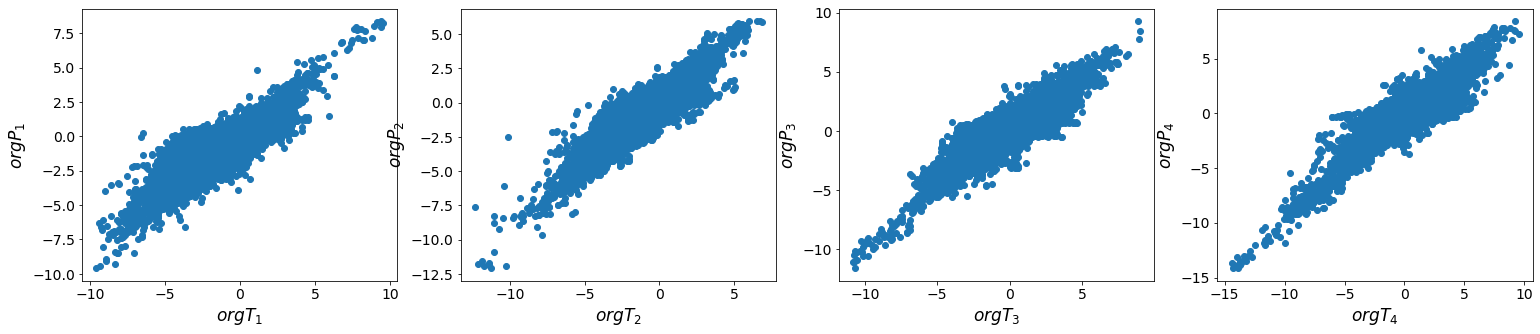

In [31]:
fig = plt.figure(figsize=[26,5])
xx = [-10,-5.5,-5.8,-15]
yy = [2.2,6.3,6.3,2.5]
for i in range(4):
    ax = fig.add_subplot(141+i)
    ax.scatter( zz_test[:,2,1,1,i], zz_predict[:,i])
    ax.set_ylabel('$orgP_{%s}$'%str(i+1),fontsize = 17)
    ax.set_xlabel('$orgT_{%s}$'%str(i+1),fontsize = 17)
    # ax.text(xx[i],yy[i],r'R$^2$:%4.2f'%r2s_2[i],fontsize = 16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    # if i ==3 : 
        # ax.set_yticks(ticks = [-15,-10,-5,0,5])
    
case = 3
# plt.show()
# fig.savefig('z_true_predict_lg_32_4_wind_pw_zz.jpeg',bbox_inches = 'tight',dpi = 100)